In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")

exponential = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Exponential")
spherical = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Spherical")
gaussian = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_88152/4219244960.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


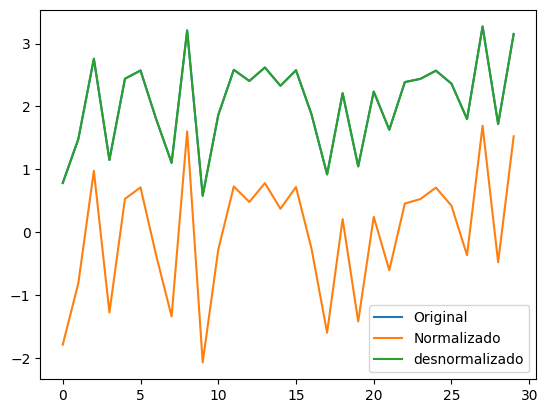

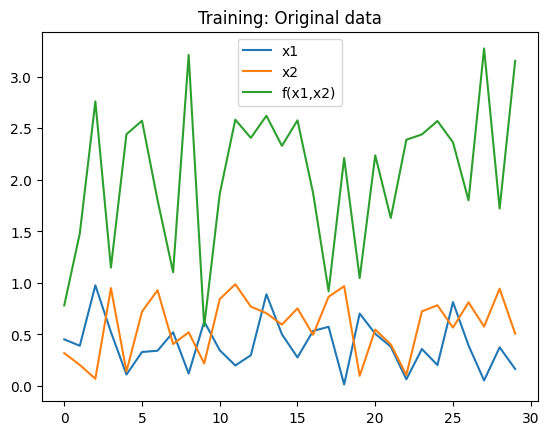

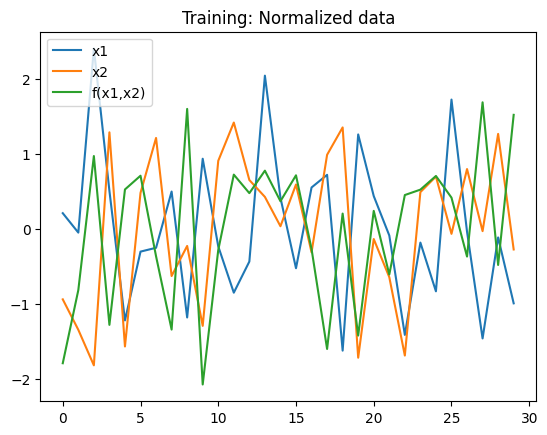

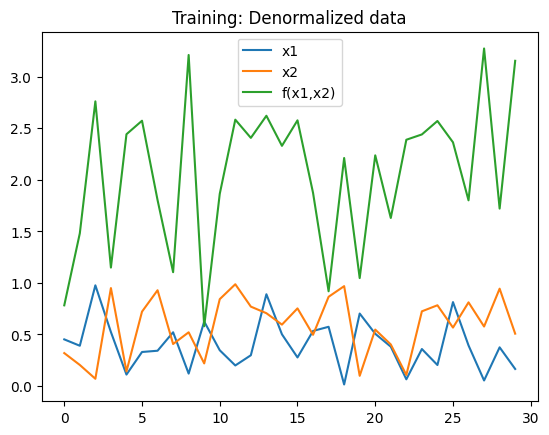

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training", True)
df_1000_norm = show_norm(df_1000)
df_exponential_norm = show_norm(pd.concat([df_training, exponential]))
df_spherical_norm = show_norm(pd.concat([df_training, spherical]))
df_gaussian_norm = show_norm(pd.concat([df_training, gaussian]))


In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-07-21 18:58:42.503768: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 18:58:42.534196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 18:58:42.534230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 18:58:42.535238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 18:58:42.540623: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 18:58:42.541583: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product

class Tester:
  def __init__(self, _df, _df_1000,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [9]:
tester = Tester(_df=df_gaussian_norm,
                _df_1000=df_1000_norm,
                run_times=25, dataset_run_times=100)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[2, 12]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[2, 12], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_24,0.938014,0.705649,0.897954,0.942210,0.930112,0.030454,0.174739,0.026271,0.031424,0.028847,0.104390,0.174512,0.889310,0.175914,116.983045,272.978550
model_1_0_23,0.933730,0.701278,0.895680,0.936950,0.925939,0.032559,0.177334,0.026856,0.034283,0.030570,0.109293,0.180441,0.881662,0.181890,116.849413,272.844918
model_1_0_22,0.931784,0.700711,0.877180,0.940297,0.922373,0.033515,0.177671,0.031619,0.032464,0.032041,0.107928,0.183071,0.878186,0.184542,116.791524,272.787029
model_1_0_21,0.898004,0.671986,0.832294,0.912993,0.890391,0.050112,0.194723,0.043175,0.047310,0.045243,0.134242,0.223856,0.817864,0.225655,115.987001,271.982506
model_1_0_20,0.896456,0.671167,0.829528,0.911820,0.888756,0.050872,0.195209,0.043887,0.047948,0.045918,0.135175,0.225548,0.815100,0.227360,115.956881,271.952386
model_1_0_18,0.851817,0.669861,0.743440,0.879712,0.840761,0.072804,0.195985,0.066049,0.065407,0.065728,0.150955,0.269822,0.735387,0.271989,115.239975,271.235480
model_1_0_17,0.849712,0.667699,0.737324,0.877875,0.837643,0.073838,0.197268,0.067624,0.066406,0.067015,0.152306,0.271731,0.731628,0.273914,115.211765,271.207270
model_1_0_19,0.875538,0.665006,0.793100,0.895451,0.866614,0.061149,0.198867,0.053265,0.056849,0.055057,0.145689,0.247284,0.777747,0.249270,115.588876,271.584381
model_1_0_13,0.822786,0.652592,0.685681,0.864150,0.812498,0.087067,0.206236,0.080919,0.073869,0.077394,0.161163,0.295071,0.683547,0.297441,114.882160,270.877665
model_1_0_12,0.819740,0.650147,0.681231,0.861739,0.809522,0.088563,0.207688,0.082065,0.075180,0.078622,0.162757,0.297596,0.678108,0.299986,114.848076,270.843580


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_18,0.989571,0.725177,0.984435,0.994058,0.989948,0.005124,0.163147,0.005346,0.002665,0.004006,0.038772,0.071581,0.981377,0.072156,120.547684,276.543189
model_1_1_17,0.989399,0.725080,0.984262,0.993972,0.989825,0.005208,0.163205,0.005406,0.002704,0.004055,0.039123,0.072169,0.981070,0.072748,120.514996,276.510501
model_1_1_16,0.989210,0.725000,0.984100,0.993874,0.989700,0.005301,0.163252,0.005461,0.002748,0.004104,0.039484,0.072811,0.980732,0.073396,120.479568,276.475073
model_1_1_2,0.965619,0.724742,0.962407,0.983641,0.974592,0.016892,0.163405,0.012912,0.007338,0.010125,0.066822,0.129967,0.938606,0.131011,118.161886,274.157391
model_1_1_1,0.963602,0.724716,0.971055,0.981408,0.977062,0.017883,0.163421,0.009942,0.008340,0.009141,0.075901,0.133727,0.935003,0.134801,118.047824,274.043329
model_1_1_20,0.991870,0.724651,0.985962,0.995063,0.991172,0.003994,0.163459,0.004822,0.002214,0.003518,0.034499,0.063201,0.985482,0.063709,121.045718,277.041223
model_1_1_19,0.991115,0.724472,0.985317,0.994675,0.990675,0.004365,0.163565,0.005043,0.002389,0.003716,0.036106,0.066069,0.984135,0.066599,120.868240,276.863745
model_1_1_21,0.991899,0.724229,0.985884,0.995010,0.991108,0.003980,0.163709,0.004848,0.002238,0.003543,0.034458,0.063090,0.985533,0.063597,121.052782,277.048287
model_1_1_14,0.987507,0.723929,0.982270,0.992736,0.988271,0.006138,0.163888,0.006090,0.003258,0.004674,0.042546,0.078344,0.977691,0.078974,120.186561,276.182066
model_1_1_22,0.991953,0.723792,0.985849,0.995007,0.991092,0.003954,0.163969,0.004860,0.002239,0.003550,0.034346,0.062877,0.985631,0.063382,121.066304,277.061809


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_1,0.993006,0.723870,0.991328,0.994639,0.992843,0.003436,0.163923,0.004308,0.002242,0.003275,0.032236,0.058621,0.987510,0.059092,121.346661,277.342166
model_1_2_0,0.992921,0.723711,0.990918,0.994695,0.992646,0.003478,0.164017,0.004511,0.002219,0.003365,0.032143,0.058975,0.987359,0.059449,121.322556,277.318061
model_1_2_16,0.997392,0.723297,0.994862,0.998024,0.996308,0.001281,0.164263,0.002552,0.000826,0.001689,0.018174,0.035794,0.995343,0.036081,123.319925,279.315430
model_1_2_17,0.997417,0.723246,0.994872,0.998037,0.996319,0.001269,0.164293,0.002548,0.000821,0.001684,0.018055,0.035625,0.995387,0.035911,123.338846,279.334351
model_1_2_19,0.997625,0.722909,0.994951,0.998060,0.996373,0.001167,0.164493,0.002508,0.000811,0.001660,0.017010,0.034158,0.995759,0.034432,123.507067,279.502572
model_1_2_18,0.997583,0.722873,0.995023,0.998066,0.996414,0.001188,0.164514,0.002472,0.000809,0.001641,0.017309,0.034460,0.995684,0.034737,123.471793,279.467298
model_1_2_20,0.997724,0.722627,0.994977,0.998125,0.996416,0.001118,0.164661,0.002495,0.000784,0.001640,0.016525,0.033443,0.995935,0.033711,123.591677,279.587181
model_1_2_2,0.993609,0.722561,0.992211,0.995389,0.993665,0.003140,0.164700,0.003869,0.001928,0.002899,0.030786,0.056037,0.988587,0.056487,121.526954,277.522459
model_1_2_8,0.995898,0.722389,0.994299,0.996643,0.995371,0.002016,0.164802,0.002832,0.001404,0.002118,0.024653,0.044895,0.992674,0.045255,122.413754,278.409259
model_1_2_14,0.997156,0.722321,0.994603,0.997835,0.996081,0.001397,0.164843,0.002681,0.000905,0.001793,0.019475,0.037378,0.994922,0.037678,123.146692,279.142197


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  73
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
2/2 [==============================] - 0s 3ms/step


KeyboardInterrupt: 